# Deep Dreams (with Caffe)

This notebook is my test of using the [Caffe](http://caffe.berkeleyvision.org/) neural network framework to produce "dream" visuals shown in the [Google Research blog post](http://googleresearch.blogspot.ch/2015/06/inceptionism-going-deeper-into-neural.html). The setup is coppied from [Google's Deep Dream Notebook](https://github.com/google/deepdream/blob/master/dream.ipynb), but the GIFs and viarable loop tests are mine.

## Dependencies
This notebook is designed to have as few dependencies as possible:
* Standard Python scientific stack: [NumPy](http://www.numpy.org/), [SciPy](http://www.scipy.org/), [PIL](http://www.pythonware.com/products/pil/), [IPython](http://ipython.org/). Those libraries can also be installed as a part of one of the scientific packages for Python, such as [Anaconda](http://continuum.io/downloads) or [Canopy](https://store.enthought.com/).
* [Caffe](http://caffe.berkeleyvision.org/) deep learning framework ([installation instructions](http://caffe.berkeleyvision.org/installation.html)).
* Google [protobuf](https://developers.google.com/protocol-buffers/) library that is used for Caffe model manipulation.
* os
* imageio

In [2]:
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

import caffe

# If your GPU supports CUDA and Caffe was built with CUDA support,
# uncomment the following to run Caffe operations on the GPU.
# caffe.set_mode_gpu()
# caffe.set_device(0) # select GPU device if multiple devices exist

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [19]:
import os
import PIL.ImageFont, PIL.ImageDraw
import imageio

## Loading DNN model
In this notebook we are going to use a [GoogLeNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet) model trained on [ImageNet](http://www.image-net.org/) dataset.
Feel free to experiment with other models from Caffe [Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo). One particularly interesting [model](http://places.csail.mit.edu/downloadCNN.html) was trained in [MIT Places](http://places.csail.mit.edu/) dataset. It produced many visuals from the [original blog post](http://googleresearch.blogspot.ch/2015/06/inceptionism-going-deeper-into-neural.html).

In [4]:
model_path = 'C:/Users/John/Documents/GitHub/caffe/models/bvlc_googlenet/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
# This model is not included with the above repo to save space, must be downloaded separately... I put it in the same folder as 
# this notebook. see https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet
# param_fn = model_path + 'bvlc_googlenet.caffemodel'
param_fn = 'bvlc_googlenet.caffemodel'

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

##  Producing dreams
Making the "dream" images is very simple. Essentially it is just a gradient ascent process that tries to maximize the L2 norm of activations of a particular DNN layer. Here are a few simple tricks that we found useful for getting good images:
* offset image by a random jitter
* normalize the magnitude of gradient ascent steps
* apply ascent across multiple scales (octaves)

First we implement a basic gradient ascent step function, applying the first two tricks:

In [5]:
def objective_L2(dst):
    dst.diff[:] = dst.data 

def make_step(net, step_size=1.5, end='inception_4c/output', 
              jitter=32, clip=True, objective=objective_L2):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    net.forward(end=end)
    objective(dst)  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)

Next we implement an ascent through different scales. We call these scales "octaves".

In [6]:
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4, 
              end='inception_4c/output', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in xrange(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

What if we feed the deepdream function its own output, after applying a little zoom to it? It turns out that this leads to an endless stream of impressions of the things that the network saw during training. Some patterns fire more often than others, suggestive of basins of attraction.
We will start the process from the same sky image as above, but after some iteration the original image becomes irrelevant; even random noise can be used as the starting point.

In [84]:
frame = np.float32(PIL.Image.open('sky1024px.jpg'))
h, w = frame.shape[:2]
s = 0.03 # scale coefficient
for frame_i in xrange(200):
    if os.path.exists("img loops/zoom%04d.jpg"%frame_i):
        # this takes quite a while, so I'll add in this if statement to skip this where already done.
        frame = np.float32(PIL.Image.open("img loops/zoom%04d.jpg"%frame_i))
        frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    else:
        frame = deepdream(net, frame)
        PIL.Image.fromarray(np.uint8(frame)).save("img loops/zoom%04d.jpg"%frame_i)
        frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)

Be careful running the code above, it can bring you into very strange realms!

In [17]:
def create_gif(file_names, file_name_out, f_duration):
    images = [imageio.imread(file_name) for file_name in file_names]
    imageio.mimwrite(file_name_out, images, duration=f_duration)
    return Image(url=file_name_out)

In [82]:
create_gif(["img loops/zoom%04d.jpg"%i for i in range(200)], 'img loops/zoomgif.gif', 1.0/20)

<img src='https://raw.githubusercontent.com/hydrospanner/Deep-Dream/master/img%20loops/zoomgif.gif'>

## Controlling dreams

The image detail generation method described above tends to produce some patterns more often the others. One easy way to improve the generated image diversity is to tweak the optimization objective. Here we show just one of many ways to do that. Let's use one more input image. We'd call it a "*guide*".

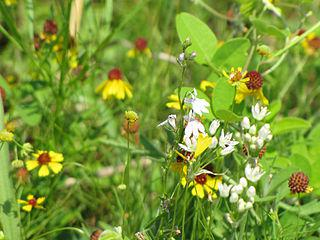

In [64]:
guide = np.float32(PIL.Image.open('flowers.jpg'))
showarray(guide)

Note that the neural network we use was trained on images downscaled to 224x224 size. So high resolution images might have to be downscaled, so that the network could pick up their features. The image we use here is already small enough.  

Now we pick some target layer and extract guide image features.

In [61]:
end='inception_3b/output'
h, w = guide.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide)
net.forward(end=end)
guide_features = dst.data[0].copy()

Instead of maximizing the L2-norm of current image activations, we try to maximize the dot-products between activations of current image, and their best matching correspondences from the guide image.

In [29]:
def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

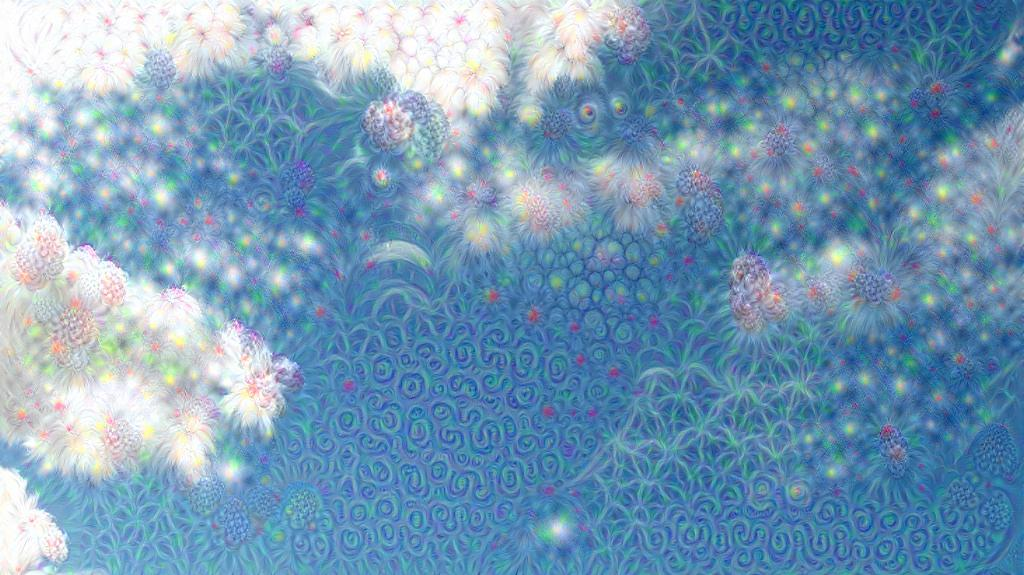

3 9 inception_3b/output (575L, 1024L, 3L)


In [67]:
_=deepdream(net, img, end=end, objective=objective_guide)

## Try different pictures
### Ashley + Red Girl Painting

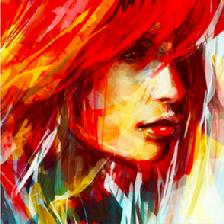

In [25]:
img = PIL.Image.open('images in/redgirl.jpg')
img.thumbnail((224, 224))
guide = np.float32(img)
showarray(guide)

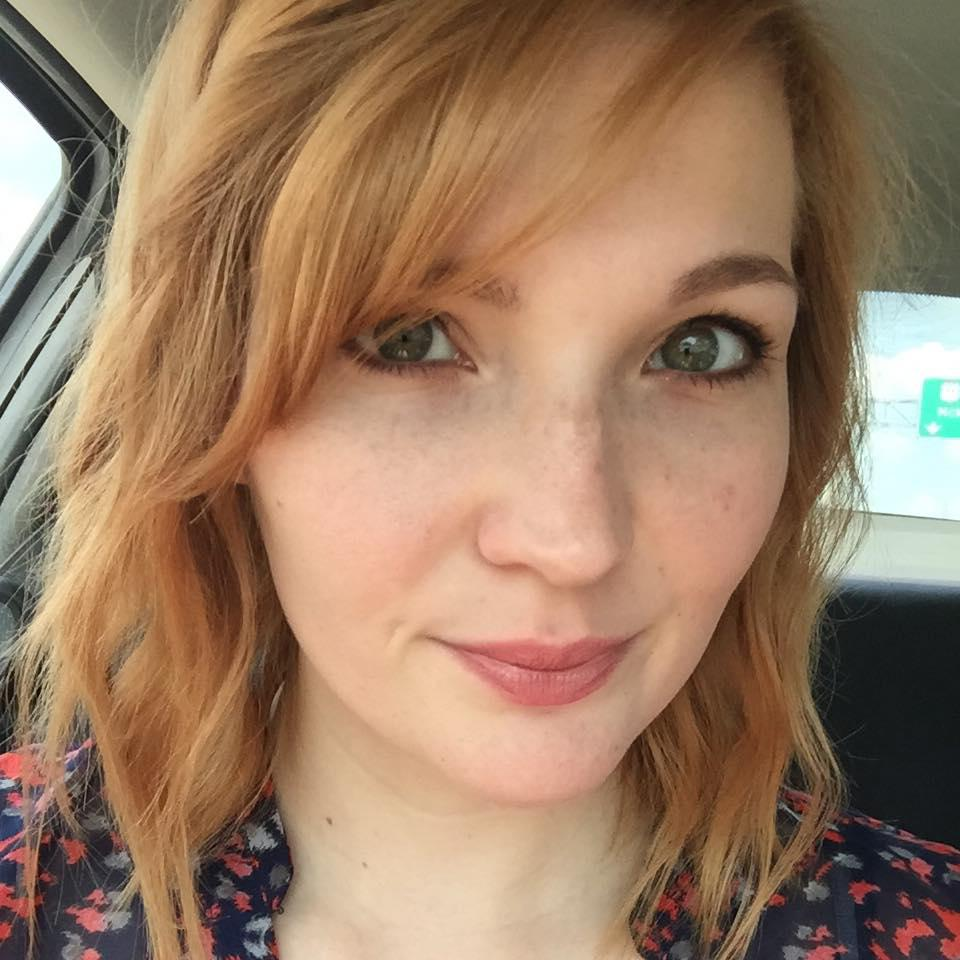

In [26]:
ashley_img = np.float32(PIL.Image.open('images in/Ashley.jpg')) 
showarray(ashley_img)

It might be better to combine these images side by side.

In [31]:
end = 'conv2/norm2'
h, w = guide.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide)
net.forward(end=end)
guide_features = dst.data[0].copy()

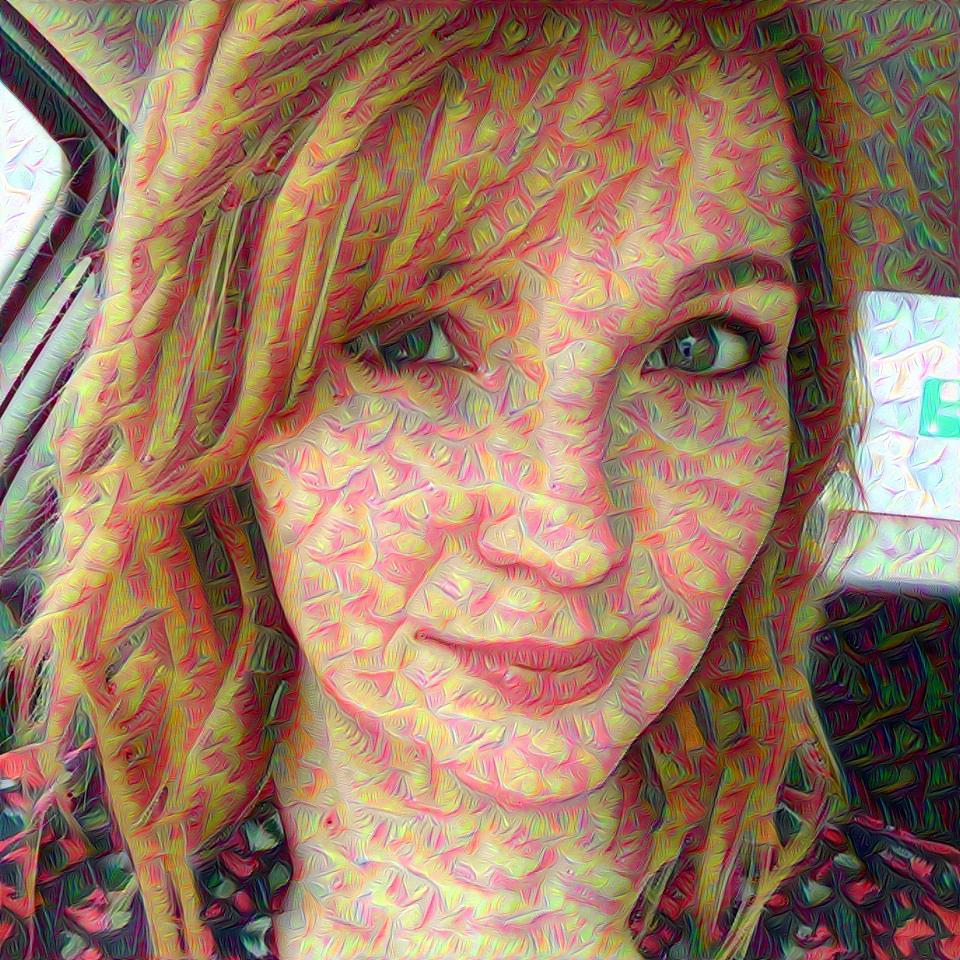

3 9 conv2/norm2 (960L, 960L, 3L)


In [32]:
_=deepdream(net, ashley_img, end=end, objective=objective_guide)

# How do the variables in the deep dream function affect the image?

## Iterations
Take the image of clouds and use a single iteration of the deepdream function. After 20 iterations, the effects become less pronounced.

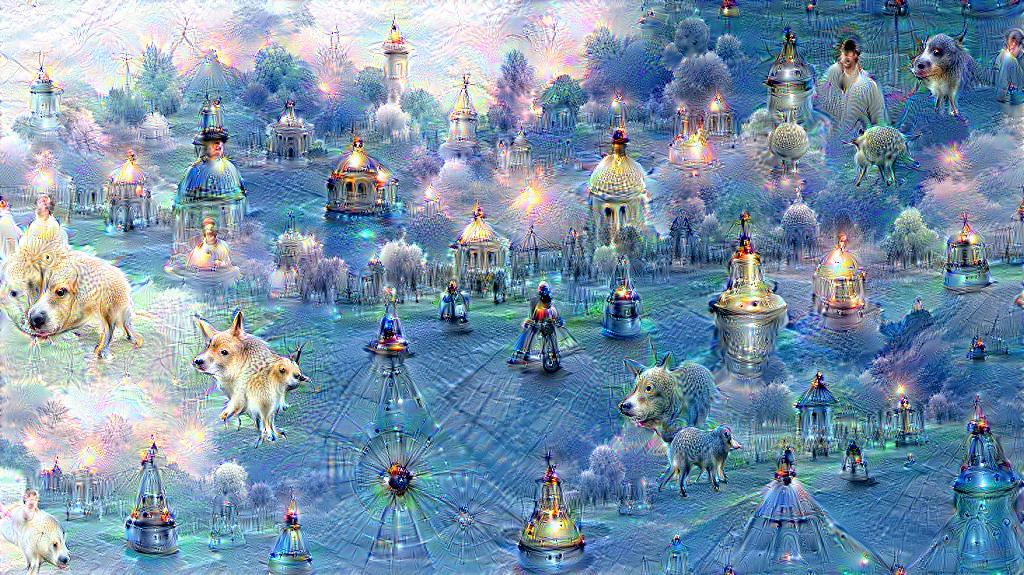

3 0 inception_4c/output (575L, 1024L, 3L)


In [77]:
img = np.float32(PIL.Image.open('sky1024px.jpg'))
for i in range(100):
    if os.path.exists("img loops/itern%04d.jpg"%i):
        # this takes quite a while, so I'll add in this if statement to skip this where already done.
        img = np.float32(PIL.Image.open("img loops/itern%04d.jpg"%i))
    else:
        img = deepdream(net, img, iter_n=1)
        PIL.Image.fromarray(np.uint8(img)).save("img loops/itern%04d.jpg"%i)

In [16]:
def img_draw2(img_in, label):
    draw = PIL.ImageDraw.Draw(img_in)
    font = PIL.ImageFont.truetype("arial.ttf", 25)
    h, w = np.float32(img_in).shape[:2]
    draw.text((50,h-50), label, (220,20,60), font=font)
    return img_in

In [39]:
def create_labeled_gif(path_names, file_name_out, label_names, f_duration):
    # Create folder with labeled images, have imageio read those, then delete the folder's contents, then the folder.
    os.mkdir('temp')
    file_names = [file_path.split('/')[-1] for file_path in path_names]
    for i, file_path in enumerate(path_names):
        labeled_img = img_draw2(PIL.Image.open(file_path), label_names[i])
        labeled_img.save('temp/' + file_names[i])
    create_gif(['temp/'+ file_name for file_name in file_names], file_name_out, f_duration)
    # delete temp files and directory
    temp_path_files = os.listdir(os.getcwd() + '\\temp')
    for file_name in temp_path_files:
        os.remove('temp/' + file_name)
    os.rmdir('temp')
    return Image(url=file_name_out)

In [45]:
create_labeled_gif(['sky1024px.jpg'] + ["img loops/itern%04d.jpg"%i for i in range(30)],
                   'img loops/labelediterngif.gif',
                   ['iteration: {}'.format(i) for i in range(0, 31)],
                   [2] + [1.0/3]*30) # the original image will last longer

<img src='https://raw.githubusercontent.com/hydrospanner/Deep-Dream/master/img%20loops/labelediterngif.gif'>

## Octaves
Octaves appear to control the size of the enhanced patterns.

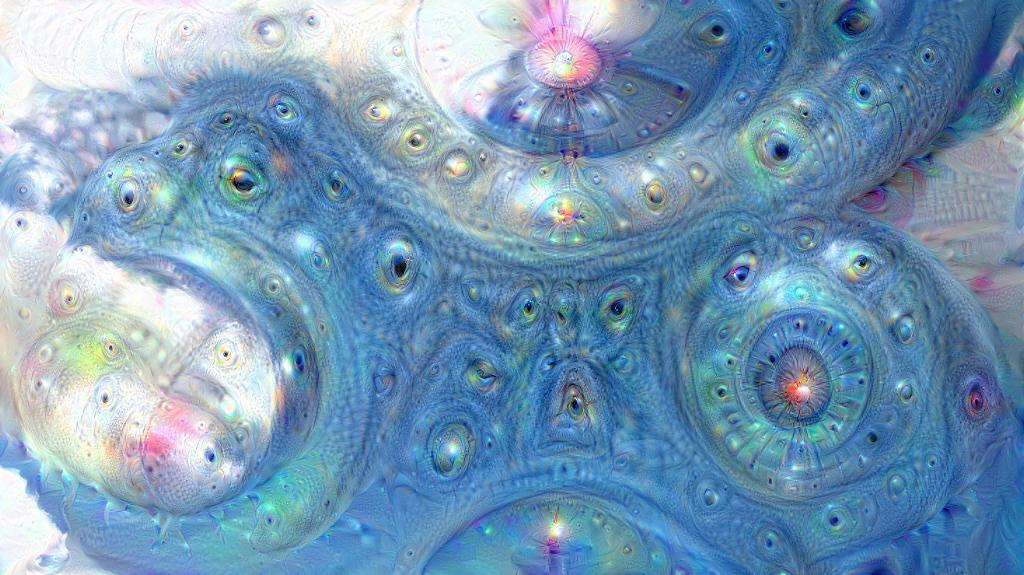

9 9 inception_4c/output (575L, 1024L, 3L)


In [106]:
img = np.float32(PIL.Image.open('sky1024px.jpg'))
for i in range(11):
    new_img = deepdream(net, img, octave_n=i)
    PIL.Image.fromarray(np.uint8(new_img)).save("img loops/iterOctave%04d.jpg"%i)

In [109]:
create_labeled_gif(["img loops/iterOctave%04d.jpg"%i for i in range(11)],
                   'img loops/iterOctaves.gif',
                   ['octaves: {}'.format(i) for i in range(11)],
                   1.0)

<img src='https://raw.githubusercontent.com/hydrospanner/Deep-Dream/master/img%20loops/iterOctaves.gif'>

## Layers
The complexity of the details generated depends on which layer's activations we try to maximize. Higher layers produce complex features, while lower ones enhance edges and textures, giving the image an impressionist feeling.   
Here I'll loop through every available layer and display it in a tiled format. 

In [12]:
img = np.float32(PIL.Image.open('sky1024px.jpg'))
layer_list = net.blobs.keys()
# Some layers were not found in the pycaffe layers. It appears that any 'split' layer doesn't work.
layer_list = [layer for layer in layer_list if not '_split_' in layer]
# The last three layers return a black image or cause Python to crash.
layer_list = layer_list[:-3]
for layer in layer_list:
    file_name = layer.replace('/', '-')
    if not os.path.exists("img loops/layer-{}.jpg".format(file_name)):
        new_img = deepdream(net, img, end=layer)
        PIL.Image.fromarray(np.uint8(new_img)).save("img loops/layer-{}.jpg".format(file_name))

In [13]:
len(layer_list)

82

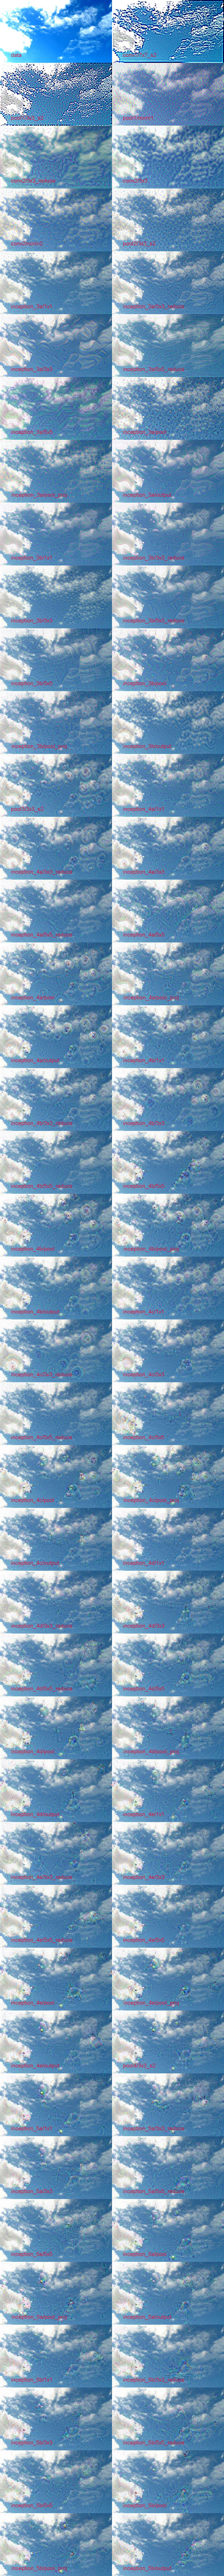

In [78]:
file_path_list = ["img loops/layer-{}.jpg".format(layer.replace('/', '-')) for layer in layer_list]
images = map(PIL.Image.open, file_path_list)
# resize the images and add the layer title
new_size = (512, 287)
new_images = []
for i, img in enumerate(images):
    new_img = img.thumbnail(new_size, PIL.Image.ANTIALIAS)
    new_images.append(img_draw2(new_img, layer_list[i]))
# Combine the formatted images in a large tiled image.
columns = 2
new_im_w = new_size[0] * columns
new_im_h = len(images) * new_size[1] / columns
new_im = PIL.Image.new('RGB', (new_im_w, new_im_h))

y_offset = 0
for i, im in enumerate(new_images):
    col = i % columns
    new_im.paste(im, (new_size[0] * col, y_offset))
    if col+1 == columns: # row complete
        y_offset += im.size[1]

new_im.save('img loops/all layers.jpg')
showarray(new_im)